In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
import experiment as ex

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and outpu t formats, load data

file_name = "mango_513_1050.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp','FruitID']#
output_cols = ['DM']
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/2.00") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\2.00\mango_513_1050


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
print(f"Dataset shape is {data.shape}")

Dataset shape is (11691, 190)


In [4]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
tb = SummaryWriter(log_dir/"tb")
summary_logger = logging.getLogger("summary")



### Training the deep learners
The following cells setup our models and run a train-test evaluation.

In [5]:
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=50,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

models = {name:RandomNet(input_size=n_features,
                         n_layers=config.n_layers,
                         act_function=config.act_function,
                         n_features = config.n_features,
                         dropout=config.dropout,
                         batch_norm=config.batch_norm,
                         device=device,dtype=torch.float)
          for name, config in configs.items()}
preprocessing = Preprocess_Std()

In [6]:
ex.write_summary_head(seed,fixed_hyperparams)
ex.save_models(models,configs,log_dir)

start = datetime.datetime.now()
eval = MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
deep_scheme = DeepScheme(configs,fixed_hyperparams=fixed_hyperparams,logger="log",device=device,adaptive_lr=True)
scores, preds, model_states , train_times, test_times = eval.evaluate(models,dataset,deep_scheme,logger_name="log")

scores_final, preds_final, model_states_ls_final , train_time_deep_final, test_time_deep_final = eval.build(models,dataset,deep_scheme,logger_name="test_log")
for model, state_dict in model_states_ls_final.items():
     torch.save(state_dict.state(), log_dir / "models" / f"{model}" / f"_final")

summary_logger.info(f"Train times: {train_times}")
summary_logger.info(f"Test times: {test_times}")
ex.save_results(model_states, preds, configs, scores, log_dir,tb)

end = datetime.datetime.now()
diff = end - start
ex.write_summary(diff, models, scores)
ex.save_pred_plots(preds, models, log_dir)

scores_df = pd.DataFrame(scores)
scores_df.to_csv(log_dir / f"scores.csv", index=False)


Starting Experiment'
Seed: 1'
bs: 32'
epochs: 100'
--------------------'
Running Cross Evaluation with 5 folds'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Training extractors on 5879 instances, validating on 1929 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.606802),random_2:85825.8078(-0.901208),random_3:nan(-0.56051),random_4:nan(-0.510167),random_5:12.3019(-0.980977),random_6:113049337.8539(-0.279102),random_7:469231325.232(-0.486609),random_8:111705.5038(-0.303297),random_9:nan(-0.78428),random_10:nan(-0.2731),random_11:nan(-0.943581),random_12:14.8766(-0.360218),random_13:nan(-0.729424),random_14:7.6637(-0.385566),random_15:nan(-0.286027),random_16:20.2363(-0.862446),random_17:nan(-0.447822),random_18:15.2556(-0.259096),random_19:12.6668(-0.033556),random_20:nan(-0.232474),random_21:47.7049(-0.684561),random_22:6.245485638349516e+16(-0.111175),random_23:nan(-0.105224),random_24:nan(-0.728931),random_25:nan(-0.920616),random_26:10.7(-0.690395),random_27:nan(

In [7]:
scores_df_final = pd.DataFrame(scores_final)
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)


### Plotting deep results as a function of number of features

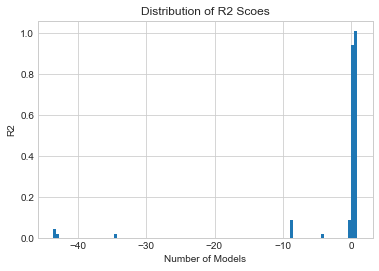

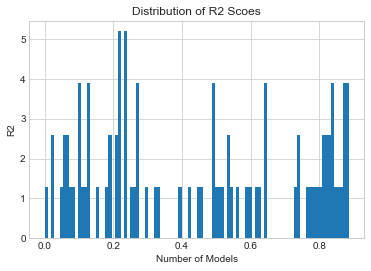

In [8]:
from matplotlib import pyplot as plt
if True:
    # plot deep results as a function of number of features

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores["R2"][name],n_features_dict[name]] for name in scores["R2"].keys()]
                           ,columns = ["name","score","n_features"])

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores["R2"][name],n_features_dict[name]] for name in scores["R2"].keys()]
                           ,columns = ["name","score","n_features"])
    to_plot = to_plot[to_plot["score"]>=0]

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot_compressed.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')
    pass

    #plot


In [10]:
summary_logger.info("------------------\n Top 5 performance on Test Set")
summary_logger.info(f"Index - Model - Val MSE - Val R2 - Test MSE - Test R2")
for i,key in enumerate(sorted(scores['MSE'],key=scores['MSE'].get)):
    if i <5:
        summary_logger.info(f"{i} - {key} - {scores['MSE'][key]} - {scores['R2'][key]} - {scores_final['MSE'][key]} - {scores_final['R2'][key]}")

------------------
 Top 5 performance on Test Set'
Index - Model - Val MSE - Val R2 - Test MSE - Test R2'
0 - random_40 - 0.6897237914557716 - 0.8857199301248981 - 0.6508638464106863 - 0.8918668781597866'
1 - random_5 - 0.7086415822101705 - 0.8825854486468384 - 0.6694135897800433 - 0.8887850636283373'
2 - random_42 - 0.7205211504315072 - 0.880617127554775 - 0.6937794134096086 - 0.8847369780113488'
3 - random_77 - 0.7501509898781183 - 0.8757077708466354 - 0.6646870041070948 - 0.8895703284226253'
4 - random_26 - 0.7614957967726379 - 0.8738280541532489 - 0.6804685044303017 - 0.8869484238466044'
